In [ ]:
!wget https://raw.githubusercontent.com/COST-ELTeC/ELTeC-eng/master/ELTeC-eng_metadata.tsv

--2023-05-01 10:39:09--  https://raw.githubusercontent.com/COST-ELTeC/ELTeC-eng/master/ELTeC-eng_metadata.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19491 (19K) [text/plain]
Saving to: ‘ELTeC-eng_metadata.tsv’

ELTeC-eng_metadata. 100%[===================>]  19.03K  --.-KB/s    in 0.001s  

2023-05-01 10:39:09 (19.5 MB/s) - ‘ELTeC-eng_metadata.tsv’ saved [19491/19491]



In [ ]:
import pandas as pd 

In [ ]:
authors_df = pd.read_csv('ELTeC-eng_metadata.tsv', sep='\t')

In [ ]:
authors_df.head(2)

,corpus-id,filename,xmlid,author-name,title,author-birth,author-death,author-gender,author-ids,reference-year,...,print-edition,provenance,title-ids,language,numwords,subgenre,narrative-perspective,size-category,reprint-count,time-slot
0,ELTeC-eng,ENG18410_Sinclair,ENG18410,"Sinclair, Catherine","Modern Flirtations: or, A Month at Harrowgate",1800,1864,F,https://viaf.org/viaf/37692813/,1841,...,NaN,NaN,NaN,eng,188876,NaN,NaN,long,low,T1
1,ELTeC-eng,ENG18440_Disraeli,ENG18440,"Disraeli, Benjamin","Coningsby: or, The New Generation",1804,1881,M,https://viaf.org/viaf/49233448/,1844,...,NaN,Chadwyck-Healey Ltd (A Bell & Howell Informati...,NaN,eng,159046,NaN,NaN,long,low,T1


## Get Wikidata Ids that we need for queries

Parse the Viaf data that we had in the metadata table

In [ ]:
import requests
from bs4 import BeautifulSoup

In [ ]:
def get_wiki_id(viaf_url: str): 
  '''
  This function takes the author link to viaf.org 
  and extracts the wikidata id from the page
  '''
  wiki_id = None
  page = requests.get(viaf_url)

  soup = BeautifulSoup(page.content, "html.parser")
  res = soup.find_all('a', {'class': "pfFlagA"})

  for r in res:
      link = r.get('href')
      if 'wikidata' in link:      
        wiki_id = link.split('/')[-1].split('#')[0]

  return wiki_id

In [ ]:
from tqdm.notebook import tqdm
tqdm.pandas()

In [ ]:
authors_metadata = pd.DataFrame()
authors_metadata['author_name'] = authors_df['author-name']
authors_metadata['viaf_link'] = authors_df['author-ids']

authors_metadata.drop_duplicates(inplace=True)
authors_metadata.reset_index(inplace=True)
authors_metadata.drop(columns='index', inplace=True)
authors_metadata

,author_name,viaf_link
0,"Sinclair, Catherine",https://viaf.org/viaf/37692813/
1,"Disraeli, Benjamin",https://viaf.org/viaf/49233448/
2,"Tupper, Martin Farquhar",https://viaf.org/viaf/44385259/
3,,https://viaf.org/viaf/72764995/
4,"Brontë, Emily",https://viaf.org/viaf/97097302/
...,...,...
75,"Hamilton, Cicely",https://viaf.org/viaf/54947993/
76,"Arlen, Michael [pseud.]",https://viaf.org/viaf/19715803/
77,"Benson, Stella",https://viaf.org/viaf/90724564/
78,"Lawrence, David Herbert",https://viaf.org/viaf/95150359/


In [ ]:
# fix invalid link

authors_metadata.loc[79].viaf_link
authors_metadata.at[79,'viaf_link'] = 'https://viaf.org/viaf/34551336/'

In [ ]:
authors_metadata['wikidata_id'] = authors_metadata.viaf_link.progress_apply(get_wiki_id)

  0%|          | 0/80 [00:00<?, ?it/s]

In [ ]:
authors_metadata

,author_name,viaf_link,wikidata_id
0,"Sinclair, Catherine",https://viaf.org/viaf/37692813/,Q5052923
1,"Disraeli, Benjamin",https://viaf.org/viaf/49233448/,Q82006
2,"Tupper, Martin Farquhar",https://viaf.org/viaf/44385259/,Q1237247
3,,https://viaf.org/viaf/72764995/,Q3102010
4,"Brontë, Emily",https://viaf.org/viaf/97097302/,Q80137
...,...,...,...
75,"Hamilton, Cicely",https://viaf.org/viaf/54947993/,Q5119353
76,"Arlen, Michael [pseud.]",https://viaf.org/viaf/19715803/,Q115683
77,"Benson, Stella",https://viaf.org/viaf/90724564/,Q2342103
78,"Lawrence, David Herbert",https://viaf.org/viaf/95150359/,Q34970


Manually add entities that were not found in the viaf database

In [ ]:
authors_metadata[authors_metadata.wikidata_id.str[0] != 'Q']

,author_name,viaf_link,wikidata_id
12,"Yonge, Charlotte Mary",https://viaf.org/viaf/71399881/,None
23,"Carroll, Lewis [pseud.]",https://viaf.org/viaf/66462036/,None
38,"Lyall, Edna [pseud.]",https://viaf.org/viaf/5734093/,None
50,"Cross, Victoria",https://viaf.org/viaf/67411362/,None


In [ ]:
authors_metadata.at[12, 'wikidata_id'] = 'Q433098'
authors_metadata.at[23, 'wikidata_id'] = 'Q38082'
authors_metadata.at[38, 'wikidata_id'] = 'Q4678251'
authors_metadata.at[50, 'wikidata_id'] = 'Q567045'

Save info to file

In [ ]:
authors_metadata.to_csv('authors_metadata.tsv', sep='\t')

In [ ]:
authors_metadata = pd.read_csv('authors_metadata.tsv', sep='\t')

Make queries about locations

In [ ]:
location_properties = pd.read_csv('query_locations.tsv', sep='\t')
location_properties = location_properties.subPropertiesLabel.values
location_properties

array(['country of citizenship', 'home venue',
       'recorded at studio or venue', 'narrative location',
       'destination point', 'operating area', 'place of detention',
       'place of marriage', 'headquarters location',
       'located in/on physical feature', 'applies to jurisdiction',
       'location of creation', 'Rate Your Music venue ID',
       'holds diplomatic passport of', 'cathedral', 'mountain range',
       'historical region', 'anatomical location', 'work location',
       'filming location', 'place of birth', 'drainage basin',
       'place of burial',
       'located in the administrative territorial entity',
       'official residence', 'located on street', 'location of formation',
       'habitat', 'country', 'capital of', 'container',
       'set in environment', 'location', 'oral history at',
       'significant place', 'residence', 'site of astronomical discovery',
       'ancestral home', 'archives at', 'country of origin',
       'geomorphological unit', 

In [ ]:
!pip install mkwikidata

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import mkwikidata

In [ ]:
def get_city_country(city_id: str):
  query = """SELECT ?wdLabel ?ps_Label ?wdpqLabel ?pq_Label {
      VALUES (?company) {(wd:""" + city_id + " )}" + \
    """
      ?company ?p ?statement .
      ?statement ?ps ?ps_ .

      ?wd wikibase:claim ?p.
      ?wd wikibase:statementProperty ?ps.

      OPTIONAL {
      ?statement ?pq ?pq_ .
      ?wdpq wikibase:qualifier ?pq .
      }

      SERVICE wikibase:label { bd:serviceParam wikibase:language "en" }
    } ORDER BY ?pq_Label ?wd ?statement ?ps_
    """
  try:
    query_result = mkwikidata.run_query(query, params={})
  except:
    print(query)
  
  time.sleep(2)

  city_locations = []

  for line in query_result['results']['bindings']:
    relation = line['wdLabel']['value']

    if relation == 'country':
      city_locations.append(line['ps_Label']['value'])

  if city_locations:
    return city_locations[-1]
  else:
    return None

In [ ]:
import time

In [ ]:
def get_location_properties(author_wiki_id: str):
  query = """SELECT ?wdLabel ?ps_Label ?wdpqLabel ?pq_Label ?ps_ {
    VALUES (?company) {(wd:""" + author_wiki_id + " )}" + \
  """
    ?company ?p ?statement .
    ?statement ?ps ?ps_ .

    ?wd wikibase:claim ?p.
    ?wd wikibase:statementProperty ?ps.

    OPTIONAL {
    ?statement ?pq ?pq_ .
    ?wdpq wikibase:qualifier ?pq .
    }

    SERVICE wikibase:label { bd:serviceParam wikibase:language "en" }
  } ORDER BY ?wd ?statement ?ps_
  """
  query_result = mkwikidata.run_query(query, params={})


  author_locations = []

  for line in query_result['results']['bindings']:
    relation = line['wdLabel']['value']

    if relation in location_properties:
      entity = line['ps_Label']['value']
      entity_id = line['ps_']['value'].split('/')[-1]

      country = get_city_country(entity_id)

      author_locations.append((relation, entity, entity_id, country))

      time.sleep(2)

  return author_locations

In [ ]:
authors_metadata.head(2)

,Unnamed: 0,author_name,viaf_link,wikidata_id
0,0,"Sinclair, Catherine",https://viaf.org/viaf/37692813/,Q5052923
1,1,"Disraeli, Benjamin",https://viaf.org/viaf/49233448/,Q82006


In [ ]:
authors_locations = pd.DataFrame()
authors_locations['author_name'] = authors_metadata['author_name']
authors_locations['author_id'] = authors_metadata['wikidata_id']

authors_locations['locations'] = authors_locations.author_id.progress_apply(get_location_properties)

  0%|          | 0/80 [00:00<?, ?it/s]

In [ ]:
authors_locations.head()

,author_name,author_id,locations,loc_type,place,place_id,country
0,"Sinclair, Catherine",Q5052923,"[(place of birth, Edinburgh, Q23436, United Ki...",NaN,NaN,NaN,NaN
1,"Disraeli, Benjamin",Q82006,"[(place of burial, St Michael and All Angels C...",NaN,NaN,NaN,NaN
2,"Tupper, Martin Farquhar",Q1237247,"[(place of birth, Greater London, Q23306, Unit...",NaN,NaN,NaN,NaN
3,,Q3102010,"[(place of birth, Sandwich, Q26163, United Kin...",NaN,NaN,NaN,NaN
4,"Brontë, Emily",Q80137,"[(place of burial, St Michael and All Angels' ...",NaN,NaN,NaN,NaN


In [ ]:
authors_locations_full = authors_locations.explode('locations')

In [ ]:
authors_locations_full

,author_name,author_id,locations,loc_type,place,place_id,country
0,"Sinclair, Catherine",Q5052923,"(place of birth, Edinburgh, Q23436, United Kin...",NaN,NaN,NaN,NaN
0,"Sinclair, Catherine",Q5052923,"(place of death, Kensington, Q288781, United K...",NaN,NaN,NaN,NaN
0,"Sinclair, Catherine",Q5052923,"(country of citizenship, United Kingdom of Gre...",NaN,NaN,NaN,NaN
1,"Disraeli, Benjamin",Q82006,"(place of burial, St Michael and All Angels Ch...",NaN,NaN,NaN,NaN
1,"Disraeli, Benjamin",Q82006,"(place of birth, London, Q84, Kingdom of Mercia)",NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
79,"Trollope, Frances Milton",Q271961,"(place of birth, Stapleton, Q7600478, United K...",NaN,NaN,NaN,NaN
79,"Trollope, Frances Milton",Q271961,"(place of death, Florence, Q2044, Kingdom of I...",NaN,NaN,NaN,NaN
79,"Trollope, Frances Milton",Q271961,"(country of citizenship, United Kingdom, Q145,...",NaN,NaN,NaN,NaN
79,"Trollope, Frances Milton",Q271961,"(country of citizenship, United Kingdom of Gre...",NaN,NaN,NaN,NaN


In [ ]:
authors_locations_full.drop(columns=['loc_type', 'place', 'place_id', 'country'], inplace=True)

In [ ]:
split = pd.DataFrame(authors_locations_full['locations'].to_list(), columns = ['loc_type', 'place', 'place_id', 'country'])

split

,loc_type,place,place_id,country
0,place of birth,Edinburgh,Q23436,United Kingdom
1,place of death,Kensington,Q288781,United Kingdom
2,country of citizenship,United Kingdom of Great Britain and Ireland,Q174193,United Kingdom of Great Britain and Ireland
3,place of burial,St Michael and All Angels Churchyard,Q96950760,United Kingdom
4,place of birth,London,Q84,Kingdom of Mercia
...,...,...,...,...
526,place of birth,Stapleton,Q7600478,United Kingdom
527,place of death,Florence,Q2044,Kingdom of Italy
528,country of citizenship,United Kingdom,Q145,United Kingdom
529,country of citizenship,United Kingdom of Great Britain and Ireland,Q174193,United Kingdom of Great Britain and Ireland


In [ ]:
authors_locations_full['loc_type'] = split['loc_type'].values
authors_locations_full['place'] = split['place'].values
authors_locations_full['place_id'] = split['place_id'].values
authors_locations_full['country'] = split['country'].values

authors_locations_full.drop(columns='locations', inplace=True)

In [ ]:
authors_locations_full

,author_name,author_id,loc_type,place,place_id,country
0,"Sinclair, Catherine",Q5052923,place of birth,Edinburgh,Q23436,United Kingdom
0,"Sinclair, Catherine",Q5052923,place of death,Kensington,Q288781,United Kingdom
0,"Sinclair, Catherine",Q5052923,country of citizenship,United Kingdom of Great Britain and Ireland,Q174193,United Kingdom of Great Britain and Ireland
1,"Disraeli, Benjamin",Q82006,place of burial,St Michael and All Angels Churchyard,Q96950760,United Kingdom
1,"Disraeli, Benjamin",Q82006,place of birth,London,Q84,Kingdom of Mercia
...,...,...,...,...,...,...
79,"Trollope, Frances Milton",Q271961,place of birth,Stapleton,Q7600478,United Kingdom
79,"Trollope, Frances Milton",Q271961,place of death,Florence,Q2044,Kingdom of Italy
79,"Trollope, Frances Milton",Q271961,country of citizenship,United Kingdom,Q145,United Kingdom
79,"Trollope, Frances Milton",Q271961,country of citizenship,United Kingdom of Great Britain and Ireland,Q174193,United Kingdom of Great Britain and Ireland


In [ ]:
authors_locations_full.to_csv('authors_locations_meta.tsv', sep='\t')

In [ ]:
authors_locations_full.drop(columns=['country'], inplace=True)

In [ ]:
authors_locations_full['country'] = authors_locations_full.place_id.progress_apply(get_city_country)

  0%|          | 0/531 [00:00<?, ?it/s]

In [ ]:
authors_locations_full

,author_name,author_id,loc_type,place,place_id,country
0,"Sinclair, Catherine",Q5052923,place of birth,Edinburgh,Q23436,United Kingdom
0,"Sinclair, Catherine",Q5052923,place of death,Kensington,Q288781,United Kingdom
0,"Sinclair, Catherine",Q5052923,country of citizenship,United Kingdom of Great Britain and Ireland,Q174193,United Kingdom of Great Britain and Ireland
1,"Disraeli, Benjamin",Q82006,place of burial,St Michael and All Angels Churchyard,Q96950760,United Kingdom
1,"Disraeli, Benjamin",Q82006,place of birth,London,Q84,United Kingdom of Great Britain and Ireland
...,...,...,...,...,...,...
79,"Trollope, Frances Milton",Q271961,place of birth,Stapleton,Q7600478,United Kingdom
79,"Trollope, Frances Milton",Q271961,place of death,Florence,Q2044,Kingdom of Italy
79,"Trollope, Frances Milton",Q271961,country of citizenship,United Kingdom,Q145,United Kingdom
79,"Trollope, Frances Milton",Q271961,country of citizenship,United Kingdom of Great Britain and Ireland,Q174193,United Kingdom of Great Britain and Ireland


In [ ]:
authors_locations_full.reset_index(inplace=True)
authors_locations_full

,index,author_name,author_id,loc_type,place,place_id,country
0,0,"Sinclair, Catherine",Q5052923,place of birth,Edinburgh,Q23436,United Kingdom
1,0,"Sinclair, Catherine",Q5052923,place of death,Kensington,Q288781,United Kingdom
2,0,"Sinclair, Catherine",Q5052923,country of citizenship,United Kingdom of Great Britain and Ireland,Q174193,United Kingdom of Great Britain and Ireland
3,1,"Disraeli, Benjamin",Q82006,place of burial,St Michael and All Angels Churchyard,Q96950760,United Kingdom
4,1,"Disraeli, Benjamin",Q82006,place of birth,London,Q84,United Kingdom of Great Britain and Ireland
...,...,...,...,...,...,...,...
526,79,"Trollope, Frances Milton",Q271961,place of birth,Stapleton,Q7600478,United Kingdom
527,79,"Trollope, Frances Milton",Q271961,place of death,Florence,Q2044,Kingdom of Italy
528,79,"Trollope, Frances Milton",Q271961,country of citizenship,United Kingdom,Q145,United Kingdom
529,79,"Trollope, Frances Milton",Q271961,country of citizenship,United Kingdom of Great Britain and Ireland,Q174193,United Kingdom of Great Britain and Ireland


In [ ]:
authors_locations_full.drop(columns=['index'], inplace=True)

In [ ]:
authors_locations_full[authors_locations_full.country.isnull()]

,author_name,author_id,loc_type,place,place_id,country,country_ISO
105,"Clive, Caroline Wigley",Q5045022,place of death,Whitfield,Q355565,None,None
250,"Yeats, William Butler",Q40213,country of citizenship,Irish Free State,Q31747,None,None


In [ ]:
authors_locations_full.at[527, 'country'] = 'Italy'
authors_locations_full.at[105, 'country'] = 'Great Britain'
authors_locations_full.at[250, 'country'] = 'Republic of Ireland'

In [ ]:
country2ISO = {'United Kingdom of Great Britain and Ireland': 'GBR',
               'Great Britain': 'GBR',
               'Kingdom of England': 'GBR',
               'Kingdom of Italy': 'ITA',
               'Italy': 'ITA',
               'Australia': 'AUS',
               'Ukraine': 'UKR',
               'South Africa': 'ZAF',
               'Second Polish Republic': 'POL',
               'Russian Empire': 'RUS',
               'Monaco': 'MCO',
               'Indonesia': 'IDN',
               'Vietnam': 'VNM',
               'Jersey': 'JEY',
               'Bulgaria': 'BGR',
               'Germany': 'DEU',
               'Republic of Ireland': 'IRL',
               'Belgium': 'BEL',
               'India': 'IND',
               'France': 'FRA',
               'United States of America': 'USA',
               'Canada': 'CAN',
               'United Kingdom': 'GBR'
               }

In [ ]:
def get_ISO(country):
  try:
    return country2ISO[country]
  except:
    print(country)
    return None

authors_locations_full['country_ISO'] = authors_locations_full.country.apply(lambda x: get_ISO(x))

In [ ]:
authors_locations_full

,author_name,author_id,loc_type,place,place_id,country,country_ISO
0,"Sinclair, Catherine",Q5052923,place of birth,Edinburgh,Q23436,United Kingdom,GBR
1,"Sinclair, Catherine",Q5052923,place of death,Kensington,Q288781,United Kingdom,GBR
2,"Sinclair, Catherine",Q5052923,country of citizenship,United Kingdom of Great Britain and Ireland,Q174193,United Kingdom of Great Britain and Ireland,GBR
3,"Disraeli, Benjamin",Q82006,place of burial,St Michael and All Angels Churchyard,Q96950760,United Kingdom,GBR
4,"Disraeli, Benjamin",Q82006,place of birth,London,Q84,United Kingdom of Great Britain and Ireland,GBR
...,...,...,...,...,...,...,...
526,"Trollope, Frances Milton",Q271961,place of birth,Stapleton,Q7600478,United Kingdom,GBR
527,"Trollope, Frances Milton",Q271961,place of death,Florence,Q2044,Italy,ITA
528,"Trollope, Frances Milton",Q271961,country of citizenship,United Kingdom,Q145,United Kingdom,GBR
529,"Trollope, Frances Milton",Q271961,country of citizenship,United Kingdom of Great Britain and Ireland,Q174193,United Kingdom of Great Britain and Ireland,GBR


In [ ]:
authors_locations_full.to_csv('authors_locations_ISO.tsv', sep='\t')

In [ ]:
authors_locations_full.groupby(['country_ISO'])['author_name'].count().sort_values()

country_ISO
AUS      1
UKR      1
RUS      1
POL      1
MCO      1
VNM      1
IDN      1
ZAF      1
JEY      2
BGR      2
DEU      3
BEL      3
IND      4
IRL      4
ITA      6
FRA     11
USA     64
CAN     66
GBR    358
Name: author_name, dtype: int64

In [ ]:
# authors_locations_full.to_csv('authors_locations_meta_full.tsv', sep='\t')

In [ ]:
authors_locations_full.groupby(['author_name'])['country_ISO'].count().sort_values()

author_name
                                             2
Malet, Lucas                                 2
Griffiths, Major Arthur George Frederick     2
Skene, Felicia                               3
Sinclair, Catherine                          3
                                            ..
Conrad, Joseph                              13
Dickens, Charles                            14
Chesterton, Gilbert Keith                   15
Forster, Edward Morgan                      33
Woolf, Virginia                             34
Name: country_ISO, Length: 80, dtype: int64

In [ ]:
authors_locations_full['loc_type'].unique()

array(['place of birth', 'place of death', 'country of citizenship',
       'place of burial', 'archives at', 'work location', 'residence'],
      dtype=object)

In [ ]:
authors_locations_full.groupby(['loc_type'])['loc_type'].count()

loc_type
archives at               150
country of citizenship    128
place of birth             92
place of burial            41
place of death             86
residence                  19
work location              15
Name: loc_type, dtype: int64

In [ ]:
loc_stat = authors_locations_full.groupby('author_name').aggregate({'loc_type': 'value_counts'}).unstack(level=-1).fillna(0.0)
loc_stat[loc_stat.sum(axis=1) - loc_stat[('loc_type', 'archives at')] <= 1.0]

Empty DataFrame
Columns: [(loc_type, archives at), (loc_type, country of citizenship), (loc_type, place of birth), (loc_type, place of burial), (loc_type, place of death), (loc_type, residence), (loc_type, work location)]
Index: []

In [ ]:
!wget https://raw.githubusercontent.com/polyankaglade/ELTeC-eng-loc/main/authors/authors_geo_TOVERIFY.tsv

--2023-05-02 10:09:26--  https://raw.githubusercontent.com/polyankaglade/ELTeC-eng-loc/main/authors/authors_geo_TOVERIFY.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 121804 (119K) [text/plain]
Saving to: ‘authors_geo_TOVERIFY.tsv’

authors_geo_TOVERIF 100%[===================>] 118.95K  --.-KB/s    in 0.01s   

2023-05-02 10:09:26 (8.90 MB/s) - ‘authors_geo_TOVERIFY.tsv’ saved [121804/121804]



In [ ]:
import pandas as pd

In [ ]:
authors_loc = pd.read_csv('authors_geo_TOVERIFY.tsv', sep='\t')

In [ ]:
authors_loc

,author_name,author_id,loc_type,place,place_id,country,country_ISO,place_full,LongLabel,Addr_type,...,AddNum,City,Subregion,Region,CntryName,Country,x,y,score,error
0,"Sinclair, Catherine",Q5052923,place of birth,Edinburgh,Q23436,United Kingdom,GBR,"Edinburgh, United Kingdom","Edinburgh, City of Edinburgh, Scotland, GBR",Locality,...,NaN,Edinburgh,City of Edinburgh,Scotland,United Kingdom,GBR,-3.189107,55.953339,100.00,NaN
1,"Sinclair, Catherine",Q5052923,place of death,Kensington,Q288781,United Kingdom,GBR,"Kensington, United Kingdom","Kensington, Liverpool, Merseyside, England, GBR",Locality,...,NaN,Liverpool,Merseyside,England,United Kingdom,GBR,-2.947896,53.412076,100.00,NaN
2,"Sinclair, Catherine",Q5052923,country of citizenship,United Kingdom of Great Britain and Ireland,Q174193,United Kingdom of Great Britain and Ireland,GBR,"United Kingdom of Great Britain and Ireland, U...","Ireland, Bedfordshire, England, GBR",Locality,...,NaN,Ireland,Bedfordshire,England,United Kingdom,GBR,-0.347548,52.060693,75.48,NaN
3,"Disraeli, Benjamin",Q82006,place of burial,St Michael and All Angels Churchyard,Q96950760,United Kingdom,GBR,"St Michael and All Angels Churchyard, United K...","St Michael and All Angels, Dawlish Road, Alphi...",POI,...,NaN,Exeter,Devon,England,United Kingdom,GBR,-3.532540,50.699420,88.64,NaN
4,"Disraeli, Benjamin",Q82006,place of birth,London,Q84,United Kingdom of Great Britain and Ireland,GBR,"London, United Kingdom of Great Britain and Ir...",United Kingdom of Great Britain and Northern I...,Locality,...,NaN,NaN,NaN,NaN,United Kingdom,GBR,-1.969560,53.408387,93.63,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
411,"Trollope, Frances Milton",Q271961,place of birth,Stapleton,Q7600478,United Kingdom,GBR,"Stapleton, United Kingdom","Stapleton, Bristol, England, GBR",Locality,...,NaN,Stapleton,Bristol,England,United Kingdom,GBR,-2.554724,51.481298,100.00,NaN
412,"Trollope, Frances Milton",Q271961,place of death,Florence,Q2044,Italy,ITA,"Florence, Italy","Florence, ITA",Locality,...,NaN,Florence,Florence,Toscane,Italie,ITA,11.255010,43.782370,100.00,NaN
413,"Trollope, Frances Milton",Q271961,country of citizenship,United Kingdom,Q145,United Kingdom,GBR,"United Kingdom, United Kingdom",United Kingdom,Locality,...,NaN,NaN,NaN,NaN,United Kingdom,GBR,-1.969560,53.408387,100.00,NaN
414,"Trollope, Frances Milton",Q271961,country of citizenship,United Kingdom of Great Britain and Ireland,Q174193,United Kingdom of Great Britain and Ireland,GBR,"United Kingdom of Great Britain and Ireland, U...","Ireland, Bedfordshire, England, GBR",Locality,...,NaN,Ireland,Bedfordshire,England,United Kingdom,GBR,-0.347548,52.060693,75.48,NaN


In [ ]:
len(authors_loc.LongLabel.unique())

187

In [ ]:
counts = pd.DataFrame(authors_loc.groupby(['country_ISO'])['author_name'].count().sort_values(ascending=False))

In [ ]:
country2ISO = {'United Kingdom of Great Britain and Ireland': 'GBR',
               'Great Britain': 'GBR',
               'Kingdom of England': 'GBR',
               'Kingdom of Italy': 'ITA',
               'Italy': 'ITA',
               'Australia': 'AUS',
               'Ukraine': 'UKR',
               'South Africa': 'ZAF',
               'Second Polish Republic': 'POL',
               'Russian Empire': 'RUS',
               'Monaco': 'MCO',
               'Indonesia': 'IDN',
               'Vietnam': 'VNM',
               'Jersey': 'JEY',
               'Bulgaria': 'BGR',
               'Germany': 'DEU',
               'Republic of Ireland': 'IRL',
               'Belgium': 'BEL',
               'India': 'IND',
               'France': 'FRA',
               'United States of America': 'USA',
               'Canada': 'CAN',
               'United Kingdom': 'GBR'
               }

ISO2country = {value: key for key, value in country2ISO.items()}

In [ ]:
counts.reset_index(inplace=True)
counts['country_ISO'] = counts.country_ISO.apply(lambda x: ISO2country[x])

In [ ]:
counts

,country_ISO,author_name
0,United Kingdom,323
1,United States of America,36
2,Canada,15
3,France,11
4,Italy,6
5,Republic of Ireland,4
6,India,4
7,Germany,3
8,Bulgaria,2
9,Belgium,2


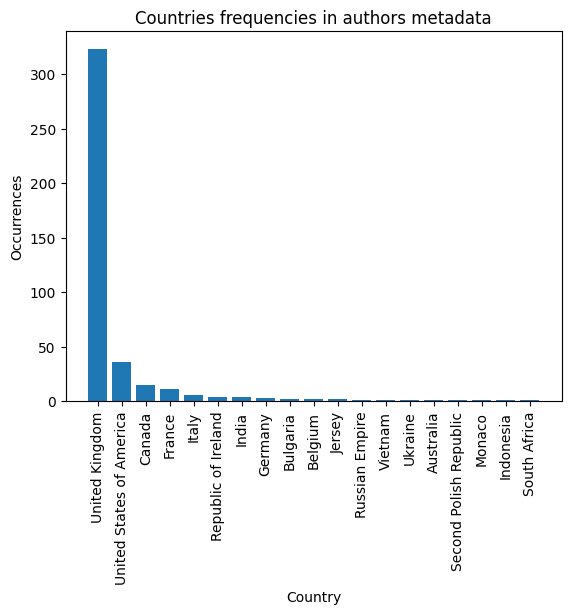

In [ ]:
import matplotlib.pyplot as plt

# create example DataFrame

# create histogram
plt.bar(counts['country_ISO'], counts['author_name'])

# set axis labels and title
plt.xlabel('Country')
plt.ylabel('Occurrences')
plt.title('Countries frequencies in authors metadata')

plt.xticks(rotation=90)

# show plot
plt.show()

In [ ]:
auth_counts = pd.DataFrame(authors_loc.groupby(['author_name'])['country_ISO'].count().sort_values(ascending=False))

In [ ]:
auth_counts

,country_ISO
author_name,
"Woolf, Virginia",11
"Brontë, Emily",10
"Dickens, Charles",10
"Conrad, Joseph",10
"Chesterton, Gilbert Keith",10
...,...
"Lyall, Edna [pseud.]",3
"MacDonald, George",3
"Griffiths, Major Arthur George Frederick",2


In [ ]:
!git clone https://github.com/COST-ELTeC/ELTeC-eng.git

Cloning into 'ELTeC-eng'...
remote: Enumerating objects: 2948, done.
remote: Counting objects: 100% (775/775), done.
remote: Compressing objects: 100% (303/303), done.
remote: Total 2948 (delta 584), reused 658 (delta 471), pack-reused 2173
Receiving objects: 100% (2948/2948), 357.63 MiB | 4.59 MiB/s, done.
Resolving deltas: 100% (2328/2328), done.
Updating files: 100% (210/210), done.


In [ ]:
!git clone https://github.com/polyankaglade/ELTeC-eng-loc.git

Cloning into 'ELTeC-eng-loc'...
remote: Enumerating objects: 235, done.
remote: Counting objects: 100% (235/235), done.
remote: Compressing objects: 100% (230/230), done.
remote: Total 235 (delta 10), reused 219 (delta 3), pack-reused 0
Receiving objects: 100% (235/235), 3.10 MiB | 4.15 MiB/s, done.
Resolving deltas: 100% (10/10), done.


In [ ]:
import os

In [ ]:
texts_loc = pd.DataFrame()

for root, dirs, files in os.walk("/content/ELTeC-eng-loc/texts/GPE_geocoded_v0/", topdown=False):
   for name in files:
      if 'errors' in name:
        continue
      
      filename = os.path.join(root, name)
      file_id = filename.split('/')[-1].split('_')[0]
      df = pd.read_csv(filename, sep='\t')
      df['text_id'] = file_id


      texts_loc = pd.concat([texts_loc,df], axis=0)

In [ ]:
texts_loc

,Location,ent_type,context,p_no,LongLabel,Addr_type,Type,StAddr,StName,AddNum,City,Subregion,Region,CntryName,Country,x,y,score,error,text_id
0,London,GPE,Educated at a small private school in the subu...,0,"London, Greater London, England, GBR",Locality,City,NaN,NaN,NaN,London,Greater London,England,United Kingdom,GBR,-0.127699,51.507408,100.0,NaN,ENG19191
1,London,GPE,was transferred to a desk in the office of a L...,0,"London, Greater London, England, GBR",Locality,City,NaN,NaN,NaN,London,Greater London,England,United Kingdom,GBR,-0.127699,51.507408,100.0,NaN,ENG19191
2,Camberwell,GPE,speculation. His own domicile being in the reg...,30,"Camberwell, Melbourne, Victoria, AUS",Locality,District,NaN,NaN,NaN,Melbourne,NaN,Victoria,Australia,AUS,145.062510,-37.836300,100.0,NaN,ENG19191
3,Bloomsbury,GPE,Faraday's lodgings in a mournful side-street i...,30,"Bloomsbury, Camden, Greater London, England, GBR",Locality,District,NaN,NaN,NaN,Camden,Greater London,England,United Kingdom,GBR,-0.126930,51.520867,100.0,NaN,ENG19191
4,Camberwell,GPE,"without thought of the Social Revolution, went...",44,"Camberwell, Melbourne, Victoria, AUS",Locality,District,NaN,NaN,NaN,Melbourne,NaN,Victoria,Australia,AUS,145.062510,-37.836300,100.0,NaN,ENG19191
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52,Paris,GPE,of affairs during the short reign of the Commu...,395,"Paris, Île-de-France, FRA",Locality,City,NaN,NaN,NaN,Paris,Paris,Île-de-France,France,FRA,2.361657,48.863698,100.0,NaN,ENG18720
53,Paris,GPE,"“You burnt Paris,” said one. “You murdered der...",396,"Paris, Île-de-France, FRA",Locality,City,NaN,NaN,NaN,Paris,Paris,Île-de-France,France,FRA,2.361657,48.863698,100.0,NaN,ENG18720
54,London,GPE,I know that he has led an infamous life in Lon...,405,"London, Greater London, England, GBR",Locality,City,NaN,NaN,NaN,London,Greater London,England,United Kingdom,GBR,-0.127699,51.507408,100.0,NaN,ENG18720
55,Paris,GPE,"and, to crown all, he went over to Paris at th...",405,"Paris, Île-de-France, FRA",Locality,City,NaN,NaN,NaN,Paris,Paris,Île-de-France,France,FRA,2.361657,48.863698,100.0,NaN,ENG18720


In [ ]:
metadata = pd.read_csv('metadata.tsv', sep='\t')
metadata.head()

,corpus-id,filename,xmlid,author-name,title,author-birth,author-death,author-gender,author-ids,reference-year,...,print-edition,provenance,title-ids,language,numwords,subgenre,narrative-perspective,size-category,reprint-count,time-slot
0,ELTeC-eng,ENG18410_Sinclair,ENG18410,"Sinclair, Catherine","Modern Flirtations: or, A Month at Harrowgate",1800,1864,F,https://viaf.org/viaf/37692813/,1841,...,NaN,NaN,NaN,eng,188876,NaN,NaN,long,low,T1
1,ELTeC-eng,ENG18440_Disraeli,ENG18440,"Disraeli, Benjamin","Coningsby: or, The New Generation",1804,1881,M,https://viaf.org/viaf/49233448/,1844,...,NaN,Chadwyck-Healey Ltd (A Bell & Howell Informati...,NaN,eng,159046,NaN,NaN,long,low,T1
2,ELTeC-eng,ENG18411_Tupper,ENG18411,"Tupper, Martin Farquhar",The Twins: A Domestic Novel,1810,1889,M,https://viaf.org/viaf/44385259/,1844,...,NaN,NaN,NaN,eng,34573,NaN,NaN,short,low,T1
3,ELTeC-eng,ENG18450_Disraeli,ENG18450,"Disraeli, Benjamin","Sybil, Or the Two Nations",1804,1881,M,https://viaf.org/viaf/49233448/,1845,...,NaN,NaN,NaN,en,158160,NaN,NaN,long,low,T1
4,ELTeC-eng,ENG18460_Reynolds,ENG18460,"Reynolds, George",The mysteries of London,1814,1879,M,https://viaf.org/viaf/72764995/,1846,...,NaN,NaN,NaN,en,839895,NaN,NaN,long,low,T1


In [ ]:
id2author = {id: author for id, author in zip(metadata.xmlid.values, metadata['author-name'].values)}

In [ ]:
id2author

{'ENG18410': 'Sinclair, Catherine',
 'ENG18440': 'Disraeli, Benjamin',
 'ENG18411': 'Tupper, Martin Farquhar',
 'ENG18450': 'Disraeli, Benjamin',
 'ENG18460': 'Reynolds, George',
 'ENG18471': 'Brontë, Emily',
 'ENG18470': 'Aguilar, Grace',
 'ENG18480': 'Thackeray, William Makepeace',
 'ENG18481': 'Dickens, Charles',
 'ENG18482': 'Gaskell, Elizabeth Cleghorn',
 'ENG18490': 'Skene, Felicia',
 'ENG18500': 'Ainsworth, William Harrison',
 'ENG18510': 'Kingsley, Charles',
 'ENG18531': 'Yonge, Charlotte Mary',
 'ENG18530': 'Dickens, Charles',
 'ENG18540': 'Dickens, Charles',
 'ENG18551': 'Trollope, Anthony',
 'ENG18552': 'Kavanagh, Julia',
 'ENG18560': 'Yonge, Charlotte Mary',
 'ENG18570': 'Brontë, Charlotte',
 'ENG18600': 'Clive, Caroline Wigley',
 'ENG18610': 'Eliot, George [pseud.]',
 'ENG18621': 'Braddon, Mary Elizabeth',
 'ENG18630': 'Craik, Dinah Maria',
 'ENG18632': 'Reade, Charles',
 'ENG18641': 'Stretton, Hesba',
 'ENG18640': 'Blackmore, Richard Doddridge',
 'ENG18652': 'Carroll, Lew

In [ ]:
texts_loc['author'] = texts_loc.text_id.apply(lambda x: id2author[x])

In [ ]:
texts_loc

,Location,ent_type,context,p_no,LongLabel,Addr_type,Type,StAddr,StName,AddNum,...,Subregion,Region,CntryName,Country,x,y,score,error,text_id,author
0,London,GPE,Educated at a small private school in the subu...,0,"London, Greater London, England, GBR",Locality,City,NaN,NaN,NaN,...,Greater London,England,United Kingdom,GBR,-0.127699,51.507408,100.0,NaN,ENG19191,"Hamilton, Cicely"
1,London,GPE,was transferred to a desk in the office of a L...,0,"London, Greater London, England, GBR",Locality,City,NaN,NaN,NaN,...,Greater London,England,United Kingdom,GBR,-0.127699,51.507408,100.0,NaN,ENG19191,"Hamilton, Cicely"
2,Camberwell,GPE,speculation. His own domicile being in the reg...,30,"Camberwell, Melbourne, Victoria, AUS",Locality,District,NaN,NaN,NaN,...,NaN,Victoria,Australia,AUS,145.062510,-37.836300,100.0,NaN,ENG19191,"Hamilton, Cicely"
3,Bloomsbury,GPE,Faraday's lodgings in a mournful side-street i...,30,"Bloomsbury, Camden, Greater London, England, GBR",Locality,District,NaN,NaN,NaN,...,Greater London,England,United Kingdom,GBR,-0.126930,51.520867,100.0,NaN,ENG19191,"Hamilton, Cicely"
4,Camberwell,GPE,"without thought of the Social Revolution, went...",44,"Camberwell, Melbourne, Victoria, AUS",Locality,District,NaN,NaN,NaN,...,NaN,Victoria,Australia,AUS,145.062510,-37.836300,100.0,NaN,ENG19191,"Hamilton, Cicely"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52,Paris,GPE,of affairs during the short reign of the Commu...,395,"Paris, Île-de-France, FRA",Locality,City,NaN,NaN,NaN,...,Paris,Île-de-France,France,FRA,2.361657,48.863698,100.0,NaN,ENG18720,"Linton, Elizabeth Lynn"
53,Paris,GPE,"“You burnt Paris,” said one. “You murdered der...",396,"Paris, Île-de-France, FRA",Locality,City,NaN,NaN,NaN,...,Paris,Île-de-France,France,FRA,2.361657,48.863698,100.0,NaN,ENG18720,"Linton, Elizabeth Lynn"
54,London,GPE,I know that he has led an infamous life in Lon...,405,"London, Greater London, England, GBR",Locality,City,NaN,NaN,NaN,...,Greater London,England,United Kingdom,GBR,-0.127699,51.507408,100.0,NaN,ENG18720,"Linton, Elizabeth Lynn"
55,Paris,GPE,"and, to crown all, he went over to Paris at th...",405,"Paris, Île-de-France, FRA",Locality,City,NaN,NaN,NaN,...,Paris,Île-de-France,France,FRA,2.361657,48.863698,100.0,NaN,ENG18720,"Linton, Elizabeth Lynn"


In [ ]:
texts_loc.to_csv('all_texts_locations.tsv', sep='\t')

Variety of countries per author

In [ ]:
texts_countries = pd.DataFrame(texts_loc.groupby(['Country'])['author'].count().sort_values(ascending=False))

Total unique locations extracted

In [ ]:
len(texts_loc.LongLabel.unique())

3271

In [ ]:
pd.DataFrame(texts_loc.groupby(['author'])['Country'].count().sort_values(ascending=False))

,Country
author,
"Disraeli, Benjamin",2294
"Reynolds, George",1925
"Lytton, Edward Bulwer",1407
"Yonge, Charlotte Mary",1264
"Thackeray, William Makepeace",1243
...,...
"Conrad, Joseph",28
"Kavanagh, Julia",22
"Clive, Caroline Wigley",20


In [ ]:
texts_diversity_countries = pd.DataFrame(texts_loc.groupby(['author'])['Country'].nunique().sort_values(ascending=False))

In [ ]:
texts_diversity_countries

In [ ]:
authors_diversity_countries = pd.DataFrame(authors_loc.groupby(['author_name'])['country_ISO'].nunique().sort_values(ascending=False))

In [ ]:
authors_diversity_countries

,country_ISO
author_name,
"Conrad, Joseph",5
"Yeats, William Butler",5
"Lee, Vernon",4
"Gissing, George",3
"Chesterton, Gilbert Keith",3
...,...
"Mallock, William Hurrell",1
"Clive, Caroline Wigley",1
"Nesbit, Edith",1


<ipython-input-125-aebfb40d1a80>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(authors_diversity_countries.index, rotation=90)


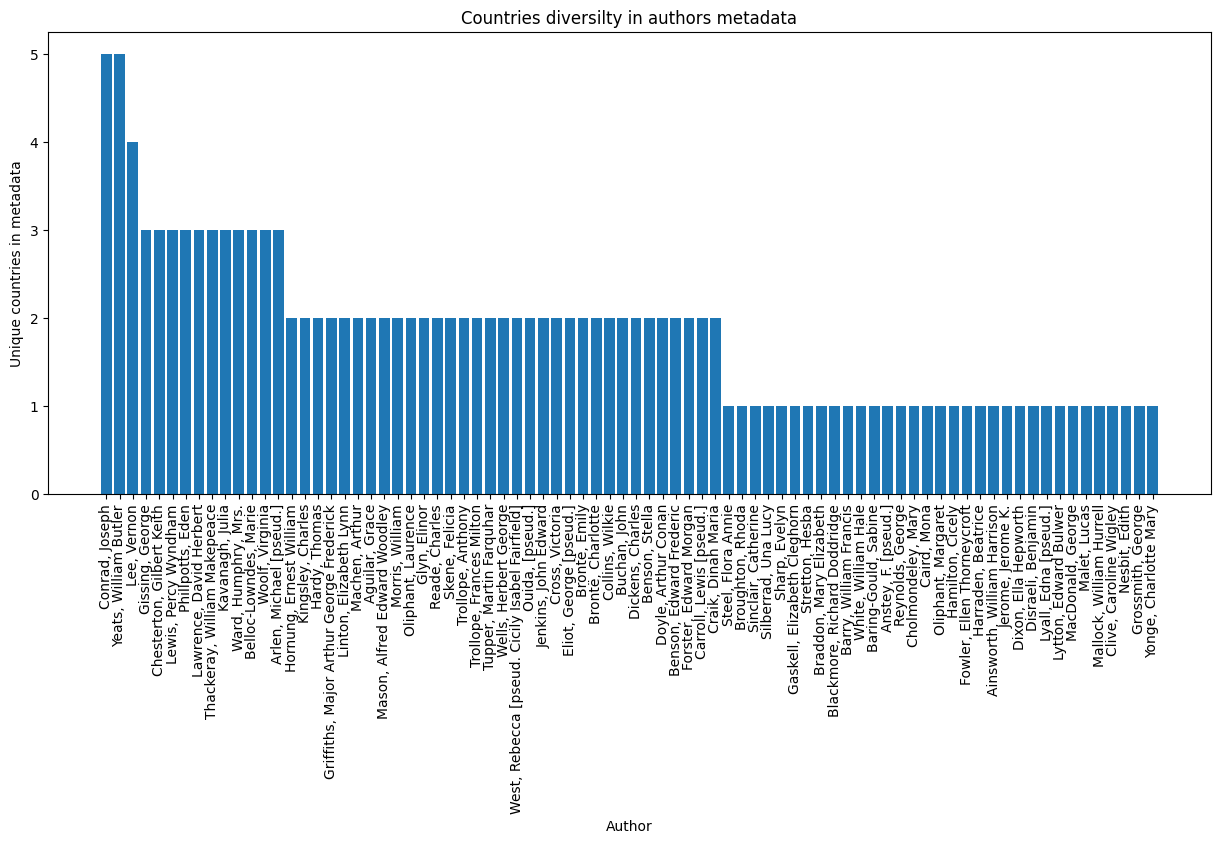

In [ ]:


fig, ax = plt.subplots(figsize=(15, 6))  # set figure size
ax.bar(authors_diversity_countries.index, authors_diversity_countries['country_ISO'])

# set axis labels and title
ax.set_xlabel('Author')
ax.set_ylabel('Unique countries in metadata')
ax.set_title('Countries diversilty in authors metadata')

# rotate x-axis tick labels
ax.set_xticklabels(authors_diversity_countries.index, rotation=90)

# show plot
plt.show()

<ipython-input-132-dc606819e878>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels((ISO2country[label] for label in  texts_countries.index[:10]), rotation=90)


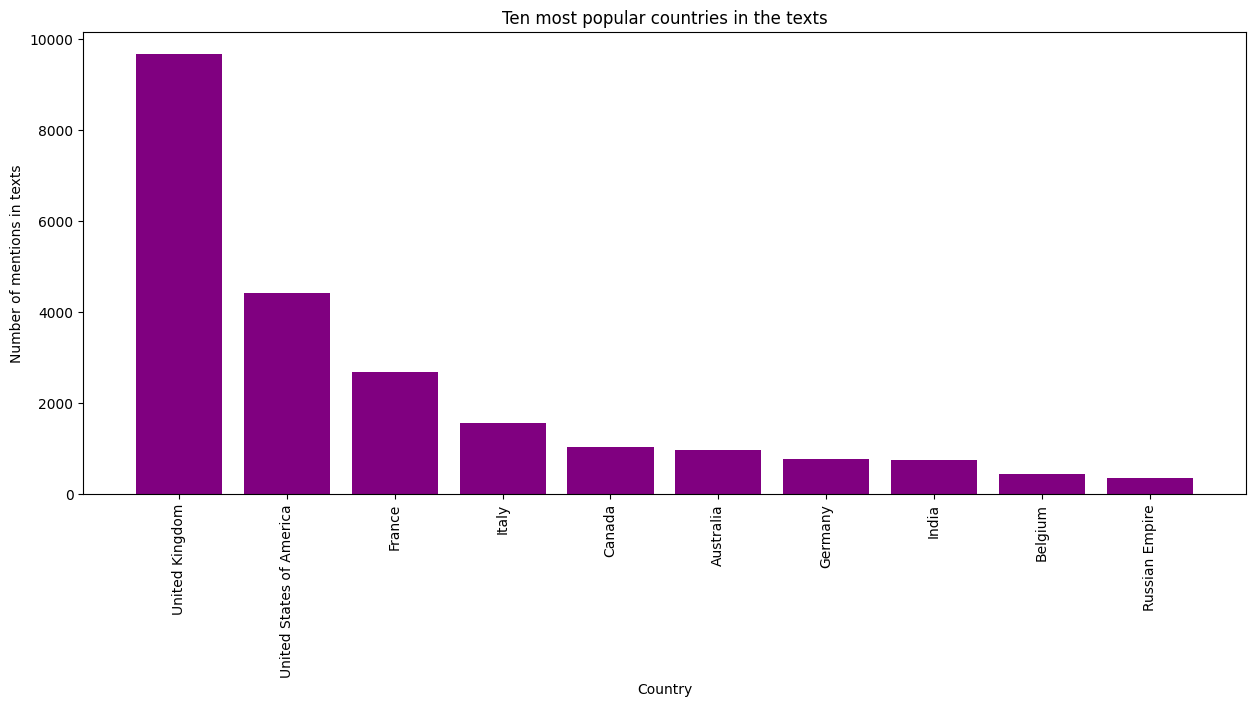

In [ ]:
# Five most popular countries in the texts


fig, ax = plt.subplots(figsize=(15, 6))  # set figure size
ax.bar(texts_countries.index[:10], texts_countries['author'][:10], color='purple')

# set axis labels and title
ax.set_xlabel('Country')
ax.set_ylabel('Number of mentions in texts')
ax.set_title('Ten most popular countries in the texts')

# rotate x-axis tick labels
ax.set_xticklabels((ISO2country[label] for label in  texts_countries.index[:10]), rotation=90)

# show plot
plt.show()

In [ ]:
texts_diversity_locs

,LongLabel
author,
"Disraeli, Benjamin",391
"Reynolds, George",378
"Ouida, [pseud.]",310
"Thackeray, William Makepeace",300
"Ward, Humphry, Mrs.",270
...,...
"Carroll, Lewis [pseud.]",12
"Lyall, Edna [pseud.]",11
"Kavanagh, Julia",10


<ipython-input-136-104b4fcb1f6d>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(texts_diversity_locs.index[:10], rotation=90)


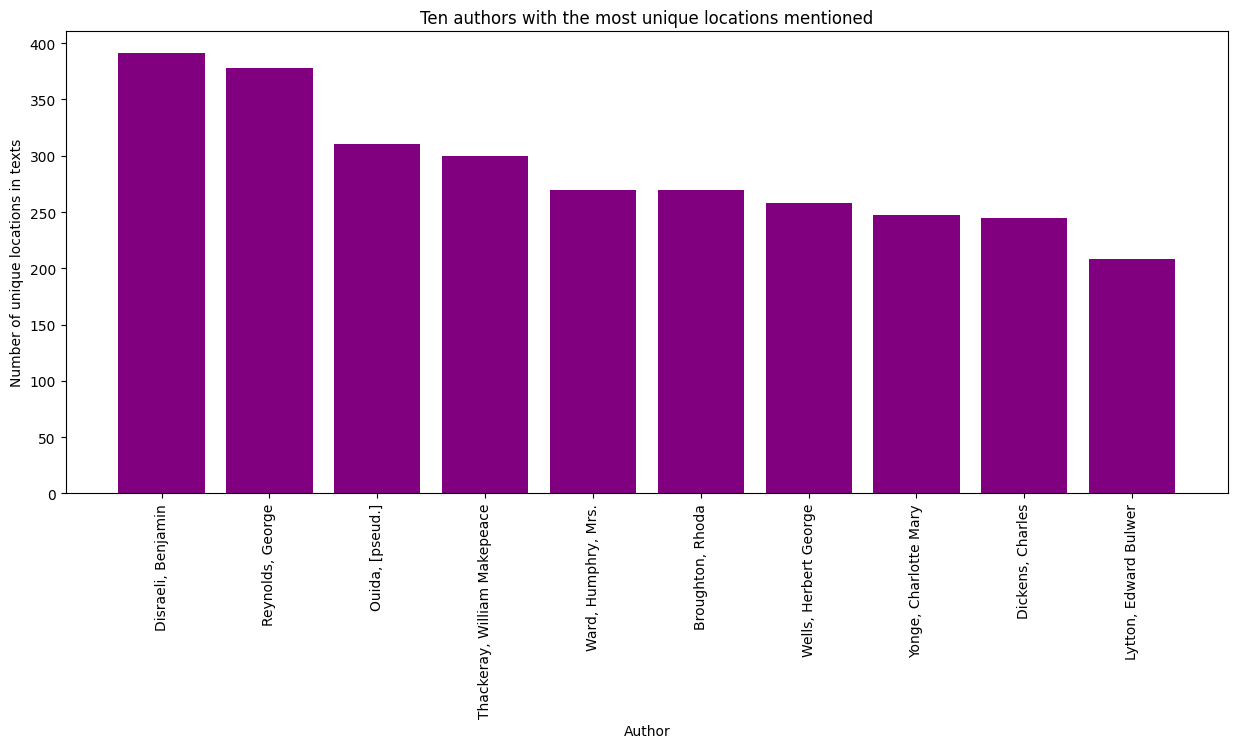

In [ ]:
# Five authors with most unique locations mentioned


fig, ax = plt.subplots(figsize=(15, 6))  # set figure size
ax.bar(texts_diversity_locs.index[:10], texts_diversity_locs['LongLabel'][:10], color='purple')

# set axis labels and title
ax.set_xlabel('Author')
ax.set_ylabel('Number of unique locations in texts')
ax.set_title('Ten authors with the most unique locations mentioned')

# rotate x-axis tick labels
ax.set_xticklabels(texts_diversity_locs.index[:10], rotation=90)

# show plot
plt.show()

In [ ]:
texts_diversity_locs = pd.DataFrame(texts_loc.groupby(['author'])['LongLabel'].nunique().sort_values(ascending=False))

In [ ]:
authors_diversity_locs = pd.DataFrame(authors_loc.groupby(['author_name'])['LongLabel'].nunique().sort_values(ascending=False))

In [ ]:
len(texts_loc.Type.unique())

158

How does the diversity in authors live correlate with diversity in texts?

In [ ]:
diversity_countries = texts_diversity_countries.join(authors_diversity_countries)

In [ ]:
diversity_countries.corr(method='spearman')

,Country,country_ISO
Country,1.000000,0.118782
country_ISO,0.118782,1.000000


In [ ]:
diversity_locs = texts_diversity_locs.join(authors_diversity_locs, lsuffix='_texts', rsuffix='_authors')

In [ ]:
diversity_locs = diversity_locs.rename(columns={'LongLabel_texts': 'texts_unique_locs',	'LongLabel_authors': 'metadata_unique_locs'})
diversity_locs

,texts_unique_locs,metadata_unique_locs
author,,
"Disraeli, Benjamin",391,6
"Reynolds, George",378,2
"Ouida, [pseud.]",310,5
"Thackeray, William Makepeace",300,6
"Ward, Humphry, Mrs.",270,5
...,...,...
"Carroll, Lewis [pseud.]",12,7
"Lyall, Edna [pseud.]",11,3
"Kavanagh, Julia",10,3


In [ ]:
diversity_locs.corr(method='spearman')

,LongLabel_texts,LongLabel_authors
LongLabel_texts,1.000000,0.251085
LongLabel_authors,0.251085,1.000000


In [ ]:
authors_loc_no_arch = authors_loc[authors_loc.loc_type != 'archived at']

In [ ]:
authors_diversity_locs = pd.DataFrame(authors_loc_no_arch.groupby(['author_name'])['LongLabel'].nunique().sort_values(ascending=False))

In [ ]:
diversity_locs = texts_diversity_locs.join(authors_diversity_locs, lsuffix='_texts', rsuffix='_authors')

In [ ]:
diversity_locs

,LongLabel_texts,LongLabel_authors
author,,
"Disraeli, Benjamin",391,6
"Reynolds, George",378,2
"Ouida, [pseud.]",310,5
"Thackeray, William Makepeace",300,6
"Ward, Humphry, Mrs.",270,5
...,...,...
"Carroll, Lewis [pseud.]",12,7
"Lyall, Edna [pseud.]",11,3
"Kavanagh, Julia",10,3


In [ ]:
diversity_locs.corr(method='spearman')

,LongLabel_texts,LongLabel_authors
LongLabel_texts,1.000000,0.251085
LongLabel_authors,0.251085,1.000000


## Sentiment analysis

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 75.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 27.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 64.0 MB/s eta 0:00:00


In [ ]:
!git clone https://github.com/polyankaglade/ELTeC-eng-loc.git

Cloning into 'ELTeC-eng-loc'...
remote: Enumerating objects: 243, done.
remote: Counting objects: 100% (243/243), done.
remote: Compressing objects: 100% (237/237), done.
remote: Total 243 (delta 13), reused 221 (delta 3), pack-reused 0
Receiving objects: 100% (243/243), 5.65 MiB | 3.39 MiB/s, done.
Resolving deltas: 100% (13/13), done.


In [ ]:
!git clone https://github.com/COST-ELTeC/ELTeC-eng.git

Cloning into 'ELTeC-eng'...
remote: Enumerating objects: 2948, done.
remote: Counting objects: 100% (775/775), done.
remote: Compressing objects: 100% (303/303), done.
remote: Total 2948 (delta 584), reused 658 (delta 471), pack-reused 2173
Receiving objects: 100% (2948/2948), 357.63 MiB | 4.48 MiB/s, done.
Resolving deltas: 100% (2328/2328), done.
Updating files: 100% (210/210), done.


In [ ]:
!wget https://raw.githubusercontent.com/polyankaglade/ELTeC-eng-loc/main/metadata.tsv

--2023-05-15 12:06:19--  https://raw.githubusercontent.com/polyankaglade/ELTeC-eng-loc/main/metadata.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18628 (18K) [text/plain]
Saving to: ‘metadata.tsv’

metadata.tsv        100%[===================>]  18.19K  --.-KB/s    in 0.002s  

2023-05-15 12:06:20 (9.17 MB/s) - ‘metadata.tsv’ saved [18628/18628]



In [ ]:
import pandas as pd
import transformers

In [ ]:
metadata = pd.read_csv('metadata.tsv', sep='\t')
xmlid2path = {xmlid: path for xmlid, path in zip(metadata.xmlid.values, metadata.filename.values)}

In [ ]:
all_locs = pd.read_csv('./ELTeC-eng-loc/texts/all_texts_locations.tsv', sep='\t')
all_locs.head(2)

,Unnamed: 0,Location,ent_type,context,p_no,LongLabel,Addr_type,Type,StAddr,StName,...,Subregion,Region,CntryName,Country,x,y,score,error,text_id,author
0,0,London,GPE,Educated at a small private school in the subu...,0,"London, Greater London, England, GBR",Locality,City,NaN,NaN,...,Greater London,England,United Kingdom,GBR,-0.127699,51.507408,100.0,NaN,ENG19191,"Hamilton, Cicely"
1,1,London,GPE,was transferred to a desk in the office of a L...,0,"London, Greater London, England, GBR",Locality,City,NaN,NaN,...,Greater London,England,United Kingdom,GBR,-0.127699,51.507408,100.0,NaN,ENG19191,"Hamilton, Cicely"


In [ ]:
all_locs['paragraph'] = texts

In [ ]:
!wget https://raw.githubusercontent.com/polyankaglade/ELTeC-eng-loc/main/points/points_filtered.csv

--2023-05-15 14:34:36--  https://raw.githubusercontent.com/polyankaglade/ELTeC-eng-loc/main/points/points_filtered.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5683683 (5.4M) [text/plain]
Saving to: ‘points_filtered.csv’

points_filtered.csv 100%[===================>]   5.42M  --.-KB/s    in 0.05s   

2023-05-15 14:34:37 (101 MB/s) - ‘points_filtered.csv’ saved [5683683/5683683]



In [ ]:
all_locs_filtered = pd.read_csv('points_filtered.csv')
all_locs_filtered.head()

,Unnamed: 0,Location,ent_type,context,p_no,LongLabel,Addr_type,Type,StAddr,StName,...,Country,x,y,score,error,filename,author,title,count,levshtein
0,0,Edinburgh,GPE,his favorite arm chair at the United Service C...,0,"Edinburgh, City of Edinburgh, Scotland, GBR",Locality,City,NaN,NaN,...,GBR,-3.189107,55.953339,100.0,NaN,ENG18410_Sinclair,"Sinclair, Catherine","Modern Flirtations: or, A Month at Harrowgate",13.0,0
1,1,Portobello,GPE,", at a retired mansion in the marine village o...",1,"Portobello, Wakefield, West Yorkshire, England...",Locality,District,NaN,NaN,...,GBR,-1.488668,53.664518,100.0,NaN,ENG18410_Sinclair,"Sinclair, Catherine","Modern Flirtations: or, A Month at Harrowgate",10.0,0
2,2,Portobello,GPE,tells me you keep a capital chop-house at Port...,19,"Portobello, Wakefield, West Yorkshire, England...",Locality,District,NaN,NaN,...,GBR,-1.488668,53.664518,100.0,NaN,ENG18410_Sinclair,"Sinclair, Catherine","Modern Flirtations: or, A Month at Harrowgate",10.0,0
3,3,Portobello,GPE,"of all dull places, the little obscure village...",20,"Portobello, Wakefield, West Yorkshire, England...",Locality,District,NaN,NaN,...,GBR,-1.488668,53.664518,100.0,NaN,ENG18410_Sinclair,"Sinclair, Catherine","Modern Flirtations: or, A Month at Harrowgate",10.0,0
4,4,Portobello,GPE,still have a tooth left for his proposed dinne...,27,"Portobello, Wakefield, West Yorkshire, England...",Locality,District,NaN,NaN,...,GBR,-1.488668,53.664518,100.0,NaN,ENG18410_Sinclair,"Sinclair, Catherine","Modern Flirtations: or, A Month at Harrowgate",10.0,0


In [ ]:
context = all_locs_filtered.context.values
all_locs['flag'] = all_locs.context.apply(lambda x: x in context)

In [ ]:
all_locs.flag.value_counts()

True     17928
False    10422
Name: flag, dtype: int64

In [ ]:
all_locs = all_locs[all_locs.flag == True]

In [ ]:
from transformers import pipeline
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")
tokenizer_kwargs = {'padding':True,'max_length':512}
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")

analyzer = pipeline("sentiment-analysis", device=0, model=model, tokenizer=tokenizer)

In [ ]:
from tqdm.notebook import tqdm
tqdm.pandas()

In [ ]:
import os
from bs4 import BeautifulSoup

def get_paragraph(xmlid, par_num):
  level1_dir = './ELTeC-eng/level1/' 

  filename = xmlid2path[xmlid] + '.xml'


  with open(level1_dir+filename, 'r') as tei: 
    soup = BeautifulSoup(tei, 'xml') 
    body = soup.find("body")
    p_elements = body.find_all('p')
    paragraph = None

    for i, p in enumerate(p_elements):        
      if i == par_num:
        paragraph = p.text
    
    return paragraph


def get_sentiment(ids, ps):
  texts = [get_paragraph(text_id, p_no) for text_id, p_no in tqdm(zip(ids, ps))]
  sentiment = analyzer(texts, truncation=True, **tokenizer_kwargs)

  return sentiment

In [ ]:
texts = []

for text_id, p_no in tqdm(zip(all_locs.text_id.values, all_locs.p_no.values), total=len(all_locs.text_id.values)):
  texts.append(get_paragraph(text_id, p_no))

  0%|          | 0/28350 [00:00<?, ?it/s]

In [ ]:
texts[0]

'William Tully was a little over three-and-twenty when he emerged from the chrysalis stage of\n     his clerkdom and became a Social Reformer. His life and doings until the age of twenty-three,\n     had given small promise of the distinction of his future career; from a mild-mannered,\n     pale-faced and under-sized boy he had developed into a mild-mannered, pale-faced little adult\n     standing five foot five in his boots. Educated at a small private school in the suburbs of\n     London, his record for conduct was practically spotless and he once took a prize for Divinity;\n     further, to the surprise and relief of his preceptors, he managed to scrape through the Senior\n     Cambridge Local Examination before he was transferred to a desk in the office of a London\n     insurance company. His preceptor-in-chief, in a neatly-written certificate, assured his future\n     employers that they would find him painstaking and obedient—and William, for the first six\n     years of his e

In [ ]:
import pickle

with open('texts.pickle', 'wb') as file:
  pickle.dump(texts, file)

In [ ]:
ex = '''William Tully was a little over three-and-twenty when he emerged from the chrysalis stage of
     his clerkdom and became a Social Reformer. His life and doings until the age of twenty-three,
     had given small promise of the distinction of his future career; from a mild-mannered,
     pale-faced and under-sized boy he had developed into a mild-mannered, pale-faced little adult
     standing five foot five in his boots. Educated at a small private school in the suburbs of
     London, his record for conduct was practically spotless and he once took a prize for Divinity;
     further, to the surprise and relief of his preceptors, he managed to scrape through the Senior
     Cambridge Local Examination before he was transferred to a desk in the office of a London
     insurance company. His preceptor-in-chief, in a neatly-written certificate, assured his future
     employers that they would find him painstaking and obedient—and William, for the first six
     years of his engagement, lived up to the character given him. His mother, a sharp-eyed,
     masterful woman, had brought him up to be painstaking and obedient; it might be said with truth
     that as long as she lived he did not know how to be otherwise. It is true he disliked his
     office superiors vaguely, for the restrictions they placed upon his wishes—just as, for the
     same reason, he vaguely disliked his mother; but his wishes being indeterminate and his
     ambition non-existent, his vague dislike never stiffened into active resentment.'''
analyzer([ex], truncation=True, **tokenizer_kwargs)

[{'label': 'POSITIVE', 'score': 0.7985788583755493}]

In [ ]:
%%timeit

for t in tqdm(texts[:100]):
   an = analyzer(t, truncation=True, batch_size=32, **tokenizer_kwargs)

  0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1080: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

1.37 s ± 186 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
def get_sentiment(text):
  return analyzer(text, truncation=True, **tokenizer_kwargs)

all_locs['sentiment'] = all_locs.paragraph.progress_apply(get_sentiment)

  0%|          | 0/17928 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1080: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
<ipython-input-45-70d562ac5d3a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_locs['sentiment'] = all_locs.paragraph.progress_apply(get_sentiment)


In [ ]:
all_locs

,Unnamed: 0,Location,ent_type,context,p_no,LongLabel,Addr_type,Type,StAddr,StName,...,Country,x,y,score,error,text_id,author,paragraph,flag,sentiment
0,0,London,GPE,Educated at a small private school in the subu...,0,"London, Greater London, England, GBR",Locality,City,NaN,NaN,...,GBR,-0.127699,51.507408,100.0,NaN,ENG19191,"Hamilton, Cicely",William Tully was a little over three-and-twen...,True,"[{'label': 'POSITIVE', 'score': 0.798578858375..."
1,1,London,GPE,was transferred to a desk in the office of a L...,0,"London, Greater London, England, GBR",Locality,City,NaN,NaN,...,GBR,-0.127699,51.507408,100.0,NaN,ENG19191,"Hamilton, Cicely",William Tully was a little over three-and-twen...,True,"[{'label': 'POSITIVE', 'score': 0.798578858375..."
7,7,England,GPE,been more ideally peaceful than the relations ...,54,"England, GBR",Locality,State or Province,NaN,NaN,...,GBR,-1.458628,52.592742,100.0,NaN,ENG19191,"Hamilton, Cicely",Griselda also was a pacifist—when it suited he...,True,"[{'label': 'POSITIVE', 'score': 0.986892282962..."
9,9,England,GPE,Middle Ages—for the simple reason that China a...,54,"England, GBR",Locality,State or Province,NaN,NaN,...,GBR,-1.458628,52.592742,100.0,NaN,ENG19191,"Hamilton, Cicely",Griselda also was a pacifist—when it suited he...,True,"[{'label': 'POSITIVE', 'score': 0.986892282962..."
16,16,London,GPE,she was not plying her epoch-making activities...,86,"London, Greater London, England, GBR",Locality,City,NaN,NaN,...,GBR,-0.127699,51.507408,100.0,NaN,ENG19191,"Hamilton, Cicely",Their selection of the Belgian Ardennes for a ...,True,"[{'label': 'POSITIVE', 'score': 0.997460842132..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28342,49,Paris,GPE,day when I wandered about the bloody-streets o...,377,"Paris, Île-de-France, FRA",Locality,City,NaN,NaN,...,FRA,2.361657,48.863698,100.0,NaN,ENG18720,"Linton, Elizabeth Lynn",I had been separated from my friends for more ...,True,"[{'label': 'NEGATIVE', 'score': 0.953660964965..."
28345,52,Paris,GPE,of affairs during the short reign of the Commu...,395,"Paris, Île-de-France, FRA",Locality,City,NaN,NaN,...,FRA,2.361657,48.863698,100.0,NaN,ENG18720,"Linton, Elizabeth Lynn","Work at the bench being impossible, being inde...",True,"[{'label': 'NEGATIVE', 'score': 0.914020001888..."
28346,53,Paris,GPE,"“You burnt Paris,” said one. “You murdered der...",396,"Paris, Île-de-France, FRA",Locality,City,NaN,NaN,...,FRA,2.361657,48.863698,100.0,NaN,ENG18720,"Linton, Elizabeth Lynn","“You burnt Paris,” said one. “You murdered\n ...",True,"[{'label': 'NEGATIVE', 'score': 0.994937181472..."
28347,54,London,GPE,I know that he has led an infamous life in Lon...,405,"London, Greater London, England, GBR",Locality,City,NaN,NaN,...,GBR,-0.127699,51.507408,100.0,NaN,ENG18720,"Linton, Elizabeth Lynn","“Friends,” he said, “I am glad that by your ho...",True,"[{'label': 'POSITIVE', 'score': 0.979457855224..."


In [ ]:
all_locs['sentiment_label'] = all_locs.sentiment.apply(lambda x: x[0]['label'])
all_locs['sentiment_score'] = all_locs.sentiment.apply(lambda x: x[0]['score'])

<ipython-input-49-cead6c8697b5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_locs['sentiment_label'] = all_locs.sentiment.apply(lambda x: x[0]['label'])
<ipython-input-49-cead6c8697b5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_locs['sentiment_score'] = all_locs.sentiment.apply(lambda x: x[0]['score'])


In [ ]:
all_locs

,Unnamed: 0,Location,ent_type,context,p_no,LongLabel,Addr_type,Type,StAddr,StName,...,y,score,error,text_id,author,paragraph,flag,sentiment,sentiment_label,sentiment_score
0,0,London,GPE,Educated at a small private school in the subu...,0,"London, Greater London, England, GBR",Locality,City,NaN,NaN,...,51.507408,100.0,NaN,ENG19191,"Hamilton, Cicely",William Tully was a little over three-and-twen...,True,"[{'label': 'POSITIVE', 'score': 0.798578858375...",POSITIVE,0.798579
1,1,London,GPE,was transferred to a desk in the office of a L...,0,"London, Greater London, England, GBR",Locality,City,NaN,NaN,...,51.507408,100.0,NaN,ENG19191,"Hamilton, Cicely",William Tully was a little over three-and-twen...,True,"[{'label': 'POSITIVE', 'score': 0.798578858375...",POSITIVE,0.798579
7,7,England,GPE,been more ideally peaceful than the relations ...,54,"England, GBR",Locality,State or Province,NaN,NaN,...,52.592742,100.0,NaN,ENG19191,"Hamilton, Cicely",Griselda also was a pacifist—when it suited he...,True,"[{'label': 'POSITIVE', 'score': 0.986892282962...",POSITIVE,0.986892
9,9,England,GPE,Middle Ages—for the simple reason that China a...,54,"England, GBR",Locality,State or Province,NaN,NaN,...,52.592742,100.0,NaN,ENG19191,"Hamilton, Cicely",Griselda also was a pacifist—when it suited he...,True,"[{'label': 'POSITIVE', 'score': 0.986892282962...",POSITIVE,0.986892
16,16,London,GPE,she was not plying her epoch-making activities...,86,"London, Greater London, England, GBR",Locality,City,NaN,NaN,...,51.507408,100.0,NaN,ENG19191,"Hamilton, Cicely",Their selection of the Belgian Ardennes for a ...,True,"[{'label': 'POSITIVE', 'score': 0.997460842132...",POSITIVE,0.997461
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28342,49,Paris,GPE,day when I wandered about the bloody-streets o...,377,"Paris, Île-de-France, FRA",Locality,City,NaN,NaN,...,48.863698,100.0,NaN,ENG18720,"Linton, Elizabeth Lynn",I had been separated from my friends for more ...,True,"[{'label': 'NEGATIVE', 'score': 0.953660964965...",NEGATIVE,0.953661
28345,52,Paris,GPE,of affairs during the short reign of the Commu...,395,"Paris, Île-de-France, FRA",Locality,City,NaN,NaN,...,48.863698,100.0,NaN,ENG18720,"Linton, Elizabeth Lynn","Work at the bench being impossible, being inde...",True,"[{'label': 'NEGATIVE', 'score': 0.914020001888...",NEGATIVE,0.914020
28346,53,Paris,GPE,"“You burnt Paris,” said one. “You murdered der...",396,"Paris, Île-de-France, FRA",Locality,City,NaN,NaN,...,48.863698,100.0,NaN,ENG18720,"Linton, Elizabeth Lynn","“You burnt Paris,” said one. “You murdered\n ...",True,"[{'label': 'NEGATIVE', 'score': 0.994937181472...",NEGATIVE,0.994937
28347,54,London,GPE,I know that he has led an infamous life in Lon...,405,"London, Greater London, England, GBR",Locality,City,NaN,NaN,...,51.507408,100.0,NaN,ENG18720,"Linton, Elizabeth Lynn","“Friends,” he said, “I am glad that by your ho...",True,"[{'label': 'POSITIVE', 'score': 0.979457855224...",POSITIVE,0.979458


In [ ]:
import pickle

with open('sentiments_paragraphs.pickle', 'wb') as file:
  pickle.dump(all_locs, file)

In [ ]:
all_locs.sentiment_label.value_counts()

NEGATIVE    9356
POSITIVE    8572
Name: sentiment_label, dtype: int64

In [ ]:
all_locs.columns

Index(['Unnamed: 0', 'Location', 'ent_type', 'context', 'p_no', 'LongLabel',
       'Addr_type', 'Type', 'StAddr', 'StName', 'AddNum', 'City', 'Subregion',
       'Region', 'CntryName', 'Country', 'x', 'y', 'score', 'error', 'text_id',
       'author', 'paragraph', 'flag', 'sentiment', 'sentiment_label',
       'sentiment_score'],
      dtype='object')

In [ ]:
cntr_sent = pd.DataFrame(all_locs.groupby('sentiment_label')['CntryName'].value_counts(ascending=True))

In [ ]:
pd.DataFrame(all_locs.groupby('CntryName')['sentiment_label'].value_counts(ascending=True))

sentiment_label
CntryName   sentiment_label                 
Afghanistan POSITIVE                       9
            NEGATIVE                      12
Algeria     NEGATIVE                      40
            POSITIVE                      50
Algérie     POSITIVE                      26
...                                      ...
Węgry       POSITIVE                       3
Zimbabwe    NEGATIVE                       9
            POSITIVE                      12
Österreich  POSITIVE                      23
            NEGATIVE                      53

[167 rows x 1 columns]

In [ ]:
len(all_locs.author.unique())

76

In [ ]:
all_locs.to_csv('all_locs_paragraph_sentiment.csv')

In [ ]:
all_locs[all_locs.CntryName == 'Turkmenistan']

,Unnamed: 0,Location,ent_type,context,p_no,LongLabel,Addr_type,Type,StAddr,StName,...,y,score,error,text_id,author,paragraph,flag,sentiment,sentiment_label,sentiment_score
3049,136,Gushy,GPE,"on an ungrateful world? Why, if that fellow Gu...",466,"Gushgy, Mary, TKM",Locality,City,NaN,NaN,...,35.27992,83.33,NaN,ENG18800,"Disraeli, Benjamin","But in August Waldershare disappeared, and at ...",True,"[{'label': 'NEGATIVE', 'score': 0.998891651630...",NEGATIVE,0.998892
3050,137,Gushy,GPE,day. I am as much robbed by that fellow Gushy ...,466,"Gushgy, Mary, TKM",Locality,City,NaN,NaN,...,35.27992,83.33,NaN,ENG18800,"Disraeli, Benjamin","But in August Waldershare disappeared, and at ...",True,"[{'label': 'NEGATIVE', 'score': 0.998891651630...",NEGATIVE,0.998892
3051,138,Gushy,GPE,world of hypocrisy and plunder. And that is wh...,467,"Gushgy, Mary, TKM",Locality,City,NaN,NaN,...,35.27992,83.33,NaN,ENG18800,"Disraeli, Benjamin",About the fall of the leaf the offices were al...,True,"[{'label': 'POSITIVE', 'score': 0.996426403522...",POSITIVE,0.996426
3207,294,Gushy,GPE,"works or not noticing them, or continually dil...",1135,"Gushgy, Mary, TKM",Locality,City,NaN,NaN,...,35.27992,83.33,NaN,ENG18800,"Disraeli, Benjamin","The morning after, Endymion was emerging from ...",True,"[{'label': 'NEGATIVE', 'score': 0.563547253608...",NEGATIVE,0.563547
3386,473,Gushy,GPE,selling forty thousand a month; I believe more...,1902,"Gushgy, Mary, TKM",Locality,City,NaN,NaN,...,35.27992,83.33,NaN,ENG18800,"Disraeli, Benjamin","“They need not have dissolved parliament,” sai...",True,"[{'label': 'NEGATIVE', 'score': 0.999136030673...",NEGATIVE,0.999136
3484,571,Gushy,GPE,have tempted me to accept one. But there is Gu...,2181,"Gushgy, Mary, TKM",Locality,City,NaN,NaN,...,35.27992,83.33,NaN,ENG18800,"Disraeli, Benjamin","“Oh, you are here!” said Mr. St. Barbe acidly ...",True,"[{'label': 'NEGATIVE', 'score': 0.984136104583...",NEGATIVE,0.984136
3485,572,Gushy,GPE,have liked it. I must say I feel for Gushy; hi...,2181,"Gushgy, Mary, TKM",Locality,City,NaN,NaN,...,35.27992,83.33,NaN,ENG18800,"Disraeli, Benjamin","“Oh, you are here!” said Mr. St. Barbe acidly ...",True,"[{'label': 'NEGATIVE', 'score': 0.984136104583...",NEGATIVE,0.984136
3486,573,Gushy,GPE,"“Gushy is not in society,” said Mr. Seymour Hicks",2182,"Gushgy, Mary, TKM",Locality,City,NaN,NaN,...,35.27992,83.33,NaN,ENG18800,"Disraeli, Benjamin","“Gushy is not in society,” said Mr. Seymour Hi...",True,"[{'label': 'NEGATIVE', 'score': 0.996474087238...",NEGATIVE,0.996474


In [ ]:
grouped = all_locs.groupby('CntryName')['sentiment_label'].value_counts()

# grouped
# convert the counts to percentages
percentages = pd.DataFrame(grouped.groupby(level=0, group_keys=False).apply(lambda x: 100 * x / float(x.sum())))

# print the resulting percentages
percentages.to_csv('countries_labels.csv')


In [ ]:
percentages[percentages.sentiment_label]

sentiment_label
CntryName   sentiment_label                 
Afghanistan NEGATIVE               57.142857
            POSITIVE               42.857143
Algeria     POSITIVE               55.555556
            NEGATIVE               44.444444
Algérie     NEGATIVE               61.194030
...                                      ...
Węgry       POSITIVE               50.000000
Zimbabwe    POSITIVE               57.142857
            NEGATIVE               42.857143
Österreich  NEGATIVE               69.736842
            POSITIVE               30.263158

[167 rows x 1 columns]

## Qualitative Analysis

In [1]:
import pandas as pd
import csv

In [2]:
par_sent = pd.read_excel('all_locs_paragraph_sentiment.xlsx')
adj_sent = pd.read_csv('all_locs_adjectives_sentiment.tsv', sep='\t')

In [9]:
label2int = {'POSITIVE': 1, 'NEGATIVE': -1}

par_sent['sentiment_value'] = par_sent.sentiment_label.apply(lambda x: label2int[x])
adj_sent['sentiment_value'] = adj_sent.sentiment_label.apply(lambda x: label2int[x])

In [28]:
par_sent_agg = pd.DataFrame(par_sent.groupby('LongLabel')['sentiment_value'].aggregate(['mean', 'count']))
adj_sent_agg = pd.DataFrame(adj_sent.groupby('LongLabel')['sentiment_value'].aggregate(['mean', 'count']))

In [29]:
par_sent_agg

,mean,count
LongLabel,,
"Ada, OK, USA",0.250000,8
"Adelaide, South Australia, AUS",0.000000,6
"Agra, Uttar Pradesh, IND",-0.324324,74
"Airlie, Angus, Scotland, GBR",-0.133333,30
"Aix, Bouches-du-Rh?ne, Provence-Alpes-C?te d'Azur, FRA",-0.222222,36
...,...,...
"Worth, IL, USA",-0.666667,6
"Yarmouth, Isle of Wight, England, GBR",-0.225806,31
"Yorkshire, VA, USA",-0.333333,30


In [30]:
adj_sent_agg

,mean,count
LongLabel,,
"2D, 18 Avenue Gambetta, 33120, Arcachon, Gironde, Nouvelle-Aquitaine, FRA",1.0,2
"A K Dying, Islampur, Dhaka, BGD",-1.0,1
"A Nu You, 123 E Kibby St, Lima, OH, 45804, USA",-1.0,1
"A P Coatings, Verna, Salcete, South Goa, Goa, 403722, IND",1.0,1
"A. V. Suitings, Gandhi Nagar, Bhilwara, Rajasthan, 311001, IND",-1.0,1
...,...,...
"Švarpliai, Šakių sen., Sakiai, Marijampolės apskritis, LTU",1.0,1
北海道帯広市西１７条南３１,-1.0,1
東京都葛飾区Ｆｏｒｂｉｔｅｚｚａ,1.0,1


In [34]:
joined = par_sent_agg.merge(adj_sent_agg, on='LongLabel', how='left', suffixes=('_paragraph', '_adjectives'))


In [36]:
joined

,mean_paragraph,count_paragraph,mean_adjectives,count_adjectives
LongLabel,,,,
"Ada, OK, USA",0.250000,8,1.000000,1.0
"Adelaide, South Australia, AUS",0.000000,6,0.333333,3.0
"Agra, Uttar Pradesh, IND",-0.324324,74,-1.000000,3.0
"Airlie, Angus, Scotland, GBR",-0.133333,30,-1.000000,1.0
"Aix, Bouches-du-Rh?ne, Provence-Alpes-C?te d'Azur, FRA",-0.222222,36,NaN,NaN
...,...,...,...,...
"Worth, IL, USA",-0.666667,6,0.142857,7.0
"Yarmouth, Isle of Wight, England, GBR",-0.225806,31,-1.000000,1.0
"Yorkshire, VA, USA",-0.333333,30,-0.103448,29.0


In [37]:
joined = joined.dropna()

In [38]:
joined

,mean_paragraph,count_paragraph,mean_adjectives,count_adjectives
LongLabel,,,,
"Ada, OK, USA",0.250000,8,1.000000,1.0
"Adelaide, South Australia, AUS",0.000000,6,0.333333,3.0
"Agra, Uttar Pradesh, IND",-0.324324,74,-1.000000,3.0
"Airlie, Angus, Scotland, GBR",-0.133333,30,-1.000000,1.0
"Aix-la-Chapelle, Nordrhein-Westfalen, DEU",-0.777778,9,0.000000,2.0
...,...,...,...,...
"Woolwich, ON, CAN",0.266667,30,-0.333333,9.0
"Worth, IL, USA",-0.666667,6,0.142857,7.0
"Yarmouth, Isle of Wight, England, GBR",-0.225806,31,-1.000000,1.0


In [42]:
joined.sort_values(['count_paragraph', 'count_adjectives'])

,mean_paragraph,count_paragraph,mean_adjectives,count_adjectives
LongLabel,,,,
"Garden, MI, USA",1.000000,1,0.333333,3.0
"Saint Kitts, KNA",1.000000,1,1.000000,3.0
"Havre, MT, USA",1.000000,1,-0.333333,6.0
"Berwyn, IL, USA",0.333333,3,-1.000000,2.0
"Mt Vernon, NY, USA",0.500000,4,1.000000,2.0
...,...,...,...,...
"Rome, ITA",-0.112861,381,-0.106383,47.0
"Hamlin, NY, USA",-0.188630,387,-0.333333,3.0
France,0.057884,501,0.084746,59.0


Take only the 200 most frequent locations

In [43]:
joined = joined.sort_values(['count_paragraph', 'count_adjectives'], ascending=False)[:200]

In [44]:
joined.sort_values(by=['mean_paragraph', 'mean_adjectives'])

,mean_paragraph,count_paragraph,mean_adjectives,count_adjectives
LongLabel,,,,
"Genoa, ITA",-0.846154,13,0.600000,5.0
"Tre-gagle, Gwent, Wales, GBR",-0.714286,14,-1.000000,1.0
"Bedford, Bedfordshire, England, GBR",-0.692308,13,-0.333333,6.0
"Shropshire, England, GBR",-0.666667,24,-0.428571,7.0
"Dunstan, Northumberland, England, GBR",-0.641026,39,-1.000000,1.0
...,...,...,...,...
"Chester, Cheshire, England, GBR",0.625000,16,-0.500000,4.0
"Jos, Jos South, Plateau, NGA",0.666667,12,1.000000,1.0
"Albany, NY, USA",0.692308,13,0.500000,4.0


In [45]:
positive_locs = ['Hainault, Redbridge, Greater London, England, GBR', 'Malta', 'Albany, NY, USA']
negative_locs = ['Tre-gagle, Gwent, Wales, GBR', 'Bedford, Bedfordshire, England, GBR', 'Shropshire, England, GBR']



Paragraph analysis

In [46]:
for pos_loc in positive_locs:
  print(f'Printing contexts for location {pos_loc}')
  paragraphs = par_sent[par_sent.LongLabel == pos_loc].paragraph.values
  for p in paragraphs:
    print(p)
    print('---------------------------------------')

  adjs = adj_sent[adj_sent.LongLabel == pos_loc].adjectives.values
  for a in adjs:
      print(a)
      print('---------------------------------------')


Printing contexts for location Hainault, Redbridge, Greater London, England, GBR
Those who came after him were two sons, between whom his millions were divided; and Adrian,_x000D_
      the eldest, in addition to his share, was made the lord of Hainault. Adrian had inherited_x000D_
      something more, and something more precious, than his father’s treasure—a not inferior_x000D_
      capacity, united, in his case, with much culture, and with a worldly ambition to which his_x000D_
      father was a stranger. So long as that father lived, Adrian had been extremely circumspect. He_x000D_
      seemed only devoted to business, and to model his conduct on that of his eminent sire. That_x000D_
      father who had recognised with pride and satisfaction his capacity, and who was without_x000D_
      jealousy, had initiated his son during his lifetime in all the secrets of his wondrous craft,_x000D_
      and had entrusted him with a leading part in their affairs. Adrian had waited in Downi

In [56]:
joined.to_csv('aggregated_sentiment_locs.tsv', sep='\t')

In [47]:
for pos_loc in negative_locs:
  print(f'Printing contexts for location {pos_loc}')
  paragraphs = par_sent[par_sent.LongLabel == pos_loc].paragraph.values
  for p in paragraphs:
    print(p)
    print('---------------------------------------')

  adjs = adj_sent[adj_sent.LongLabel == pos_loc].adjectives.values
  for a in adjs:
      print(a)
      print('---------------------------------------')

Printing contexts for location Tre-gagle, Gwent, Wales, GBR
"That be wan of Tregagle's tears," she said, "an' 'tis the voice of en as you can hear_x000D_
      howlin' in the wind. He's allus a bawlin' an' squealin', poor sawl, but you can awnly hear en_x000D_
      now an' again 'fore a storm when the gale blaws his hollerin' this way."
---------------------------------------
"Who was Tregagle?"
---------------------------------------
"He was a lawyer man wance, an' killed a many wives, an' did a many shameful deeds 'fore he_x000D_
      went dead. Then, to Bodmin Court, theer comes a law case, an' they wanted Tregagle, an' a man_x000D_
      said Tregagle was the awnly witness, and another said he wadden. The second man up an' swore_x000D_
      'If Tregagle saw it done, then I wish to God he may rise from's graave and come this minute.'_x000D_
      Then, sure enough, the ghost of Tregagle 'peared in the court-house an' shawed the man was a_x000D_
      liar. But they couldn' lay th

In [53]:
par_sent_cntr = pd.DataFrame(par_sent.groupby('Country')['sentiment_value'].aggregate(['mean', 'count']))
adj_sent_cntr = pd.DataFrame(adj_sent.groupby('Country')['sentiment_value'].aggregate(['mean', 'count']))

joined = par_sent_cntr.merge(adj_sent_cntr, on='Country', how='left', suffixes=('_paragraph', '_adjectives'))

In [65]:
joined.sort_values(['mean_adjectives', 'mean_paragraph']).head(10)

,mean_paragraph,count_paragraph,mean_adjectives,count_adjectives
Country,,,,
NFK,-0.454545,11,-1.000000,2
HRV,-0.428571,7,-1.000000,1
TTO,-0.400000,10,-1.000000,3
ETH,-0.263158,19,-1.000000,1
TON,-0.230769,13,-1.000000,1
PAK,-0.200000,10,-1.000000,4
SVN,0.263158,19,-1.000000,3
LUX,-0.375000,16,-0.666667,6
BRB,-0.111111,9,-0.500000,8


In [66]:
positive_locs = ['MCO', 'MAC', 'COL', 'GRC', 'PRT']
negative_locs = ['NFK', 'HRV', 'TTO', 'ETH', 'PAK']

In [67]:
for pos_loc in negative_locs:
  print(f'Printing contexts for location {pos_loc}')
  paragraphs = par_sent[par_sent.Country == pos_loc].paragraph.values
  for p in paragraphs:
    print(p)
    print('---------------------------------------')

  adjs = adj_sent[adj_sent.Country == pos_loc].adjectives.values
  for a in adjs:
      print(a)
      print('---------------------------------------')

Printing contexts for location NFK
How strange!—how horribly depraved and vitiated must be that state of society in which_x000D_
      hundreds of talented men are constantly employed, with large recompense, in procuring the_x000D_
      condemnation of their fellow-creatures to the scaffold, the hulks, or eternal banishment! And_x000D_
      what an idea must we entertain of our vaunted condition of consummate civilization, when we_x000D_
      behold these learned men calling to their aid every miserable chicanery, every artificial_x000D_
      technicality, and every possible exaggeration, to pursue the accused prisoner either to the_x000D_
      platform of the gibbet, to loathsome dungeons, or to the horrors of Norfolk Island. Does_x000D_
      society avenge?—or does it merely make examples of the wicked to warn others from sin? If the_x000D_
      enquirer who asks himself or us these questions, would only attend the Central Criminal Court,_x000D_
      he would hear the barrist

In [68]:
for pos_loc in positive_locs:
  print(f'Printing contexts for location {pos_loc}')
  paragraphs = par_sent[par_sent.Country == pos_loc].paragraph.values
  for p in paragraphs:
    print(p)
    print('---------------------------------------')

  adjs = adj_sent[adj_sent.Country == pos_loc].adjectives.values
  for a in adjs:
      print(a)
      print('---------------------------------------')

Printing contexts for location MCO
"We would go to the South," says Mrs. Churchill, perfectly unmoved by her granddaughter's_x000D_
      want of reverence, to which, indeed, she is thoroughly accustomed, her bright old eye_x000D_
      lightening at the notion of a_x000D_
       holiday; "we would have a week in Paris, and go to the play every night. I must_x000D_
      see Judic in this new piece. We would run over to Monaco and try our luck. If only," her_x000D_
      exhilarated tone changing to one of impatient vexation, "if only Belinda were out of the_x000D_
      way!"
---------------------------------------
"Granny," says Belinda, entering the drawing-room, walking straight up to Mrs. Churchill and_x000D_
      standing before her, not allowing her attention to be distracted even by the wagging of three_x000D_
      kind tails, distinctly addressed to her. "You and Sarah may begin to pack your boxes at once;_x000D_
      you may be off to Monaco as soon as you please; I shall 

In [70]:
print('''
A ruined castle stood in the grounds.  But having got there, what was one to do?  
The shooting was bad, the fishing indifferent, and women-folk reported the scenery as nothing much. 
 The place turned out to be in the wrong part of Shropshire, damn it, and though he 
 never damned his own property aloud, he was only waiting to get it off his hands, 
 and then to let fly.  Evie's marriage was its last appearance in public.  As soon 
 as a tenant was found, it became a house for which he never had had much use, and 
 had less now, and, like Howards End, faded into Limbo.

''')


A ruined castle stood in the grounds.  But having got there, what was one to do?  
The shooting was bad, the fishing indifferent, and women-folk reported the scenery as nothing much. 
 The place turned out to be in the wrong part of Shropshire, damn it, and though he 
 never damned his own property aloud, he was only waiting to get it off his hands, 
 and then to let fly.  Evie's marriage was its last appearance in public.  As soon 
 as a tenant was found, it became a house for which he never had had much use, and 
 had less now, and, like Howards End, faded into Limbo.


